* * * > # predict 'Free' or 'Full' in car park using tensorflow and keras.

# Outline
1. [**Data load**](#Data-load)   
2. [**Build model**](#Build-model)  
3. [**Train**](#Train)  
4. [**Evaluate model**](#Evaluate-model)

# libraries  

In [1]:
# Most of work belong to 
#https://www.kaggle.com/daggysheep/find-a-car-park

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


# Data load

In [3]:
X=[]
Z=[]
IMG_SIZE=150
FREE_DIR='../input/data/data/Free'
FULL_DIR='../input/data/data/Full'


In [4]:
def assign_label(img,label):
    return label

In [5]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,label)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
# make 'Free' data
make_train_data('Free',FREE_DIR)


100%|██████████| 1067/1067 [00:51<00:00, 20.86it/s]


In [7]:
# make 'Full' data
make_train_data('Full',FULL_DIR)


100%|██████████| 2195/2195 [01:42<00:00, 21.32it/s]


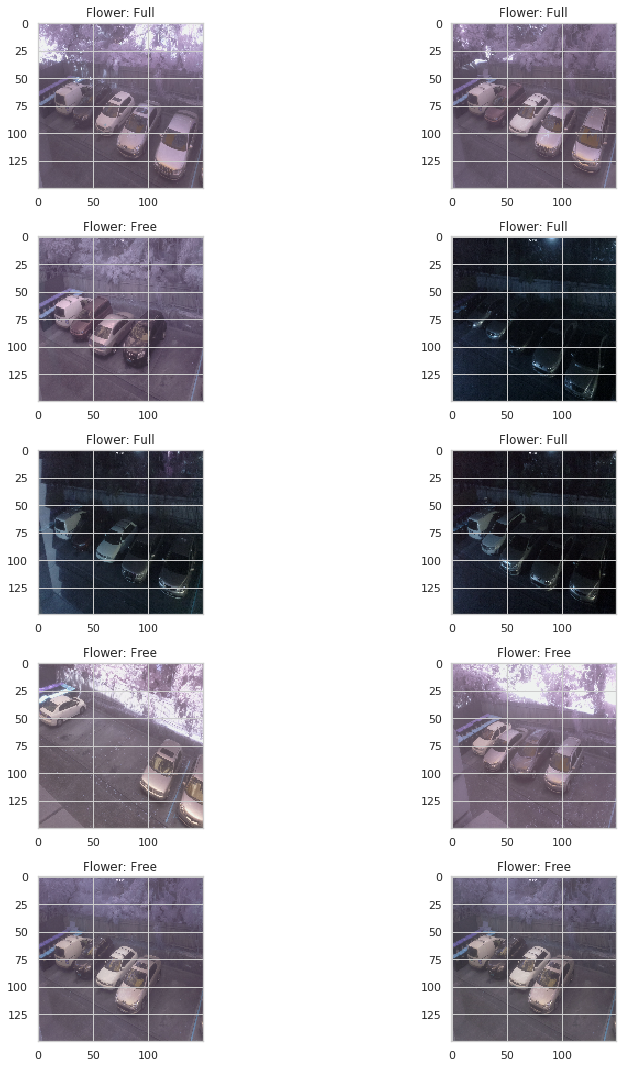

In [8]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [9]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [10]:
# separate data
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [11]:
# fix random seed
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

# Build model

In [12]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation = "softmax"))

In [13]:
batch_size=128
epochs=10

# use callback only ReduceLROnPlateau
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [14]:
# data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

# Train

In [17]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
19/19 [==============================] - 17s 910ms/step - loss: 0.6485 - acc: 0.6711 - val_loss: 0.6646 - val_acc: 0.6900
Epoch 2/10
19/19 [==============================] - 13s 691ms/step - loss: 0.5786 - acc: 0.7042 - val_loss: 0.5746 - val_acc: 0.7108
Epoch 3/10
19/19 [==============================] - 14s 726ms/step - loss: 0.5708 - acc: 0.7210 - val_loss: 0.5799 - val_acc: 0.7439
Epoch 4/10
19/19 [==============================] - 13s 708ms/step - loss: 0.5265 - acc: 0.7443 - val_loss: 0.5313 - val_acc: 0.7549
Epoch 5/10
19/19 [==============================] - 13s 690ms/step - loss: 0.4939 - acc: 0.7702 - val_loss: 0.5034 - val_acc: 0.7782
Epoch 6/10
19/19 [==============================] - 14s 718ms/step - loss: 0.5074 - acc: 0.7388 - val_loss: 0.4970 - val_acc: 0.7843
Epoch 7/10
19/19 [==============================] - 13s 687ms/step - loss: 0.4708 - acc: 0.7922 - val_loss: 0.5134 - val_acc: 0.7819
Epoch 8/10
19/19 [==============================] - 14s 731ms/step - 

# Evaluate model

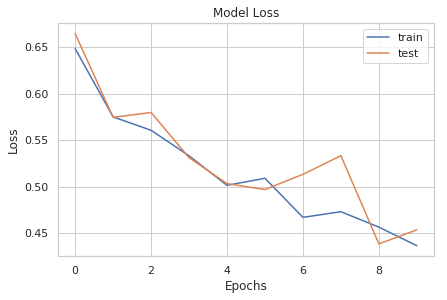

In [18]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

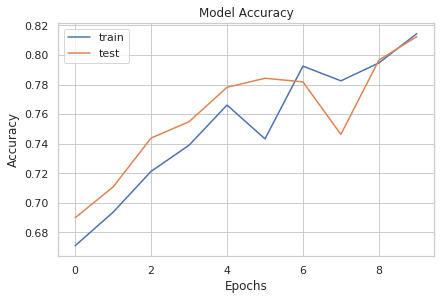

In [19]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [20]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [21]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

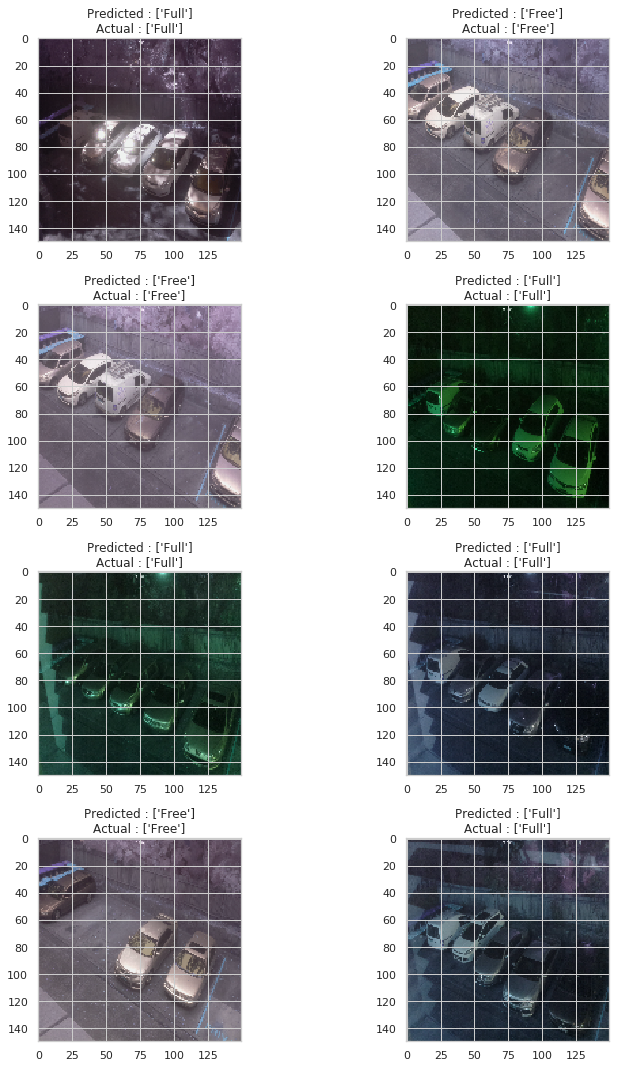

In [22]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

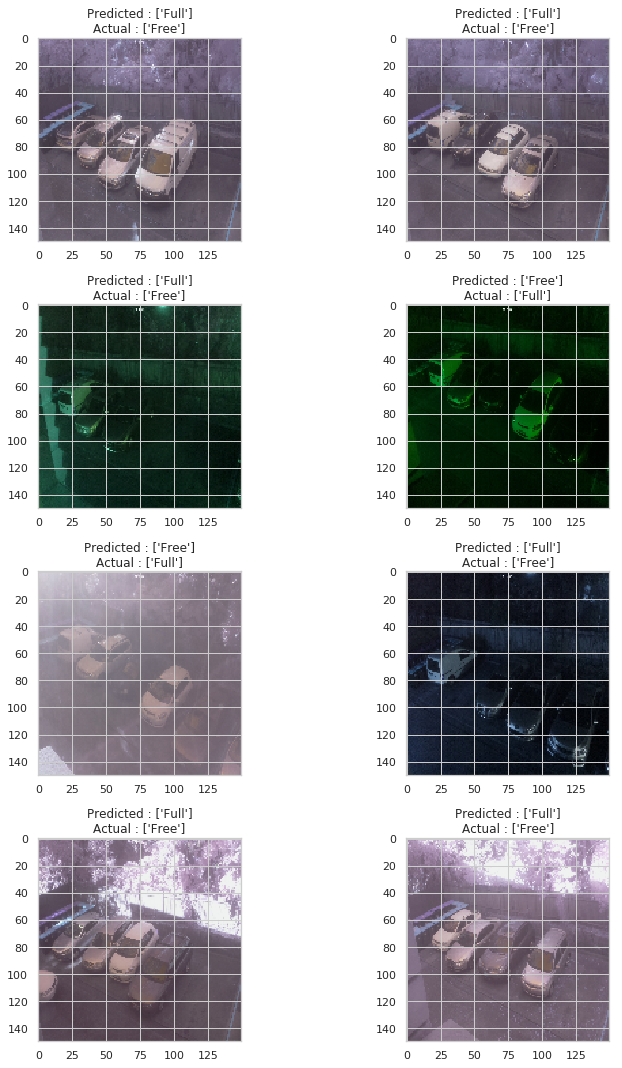

In [23]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

In [24]:

model.evaluate(x_train, y_train)

2446/2446 [==============================] - 1s 497us/step


[0.37233054137142196, 0.848732624693377]

In [25]:
model.evaluate(x_test, y_test)

816/816 [==============================] - 0s 495us/step


[0.453663660030739, 0.8125]

In [26]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = [ np.argmax(t) for t in y_test ]

Text(0.5, 58.795999999999964, 'Predicted')

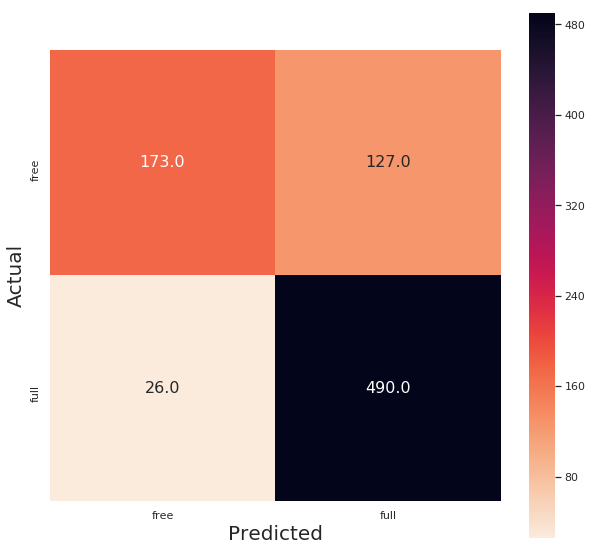

In [27]:
import seaborn as sns

label = ["free", "full"]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9, 9))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [28]:
# save model

model.save('first_cnn.h5') 


# logistic regression

In [29]:
image_size = 128


In [30]:
# **load_model**   
'''
import cv2
import tensorflow as tf
from keras.applications.resnet50 import preprocess_input 
import numpy  as np 


# loading the model 
model = tf.keras.models.load_model('./first_cnn.h5') 
'''


"\nimport cv2\nimport tensorflow as tf\nfrom keras.applications.resnet50 import preprocess_input \nimport numpy  as np \n\n\n# loading the model \nmodel = tf.keras.models.load_model('./first_cnn.h5') \n"

In [31]:
import random
#most of work was inspired from here 
# https://www.kaggle.com/gulsahdemiryurek/image-classification-with-logistic-regression/notebook

In [32]:

FREE_DIR='../input/data/data/Free'
FULL_DIR='../input/data/data/Full'

In [33]:
#maping free to be clean

FREE_filenames = os.listdir(FREE_DIR)
FREE_filenames.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(FREE_filenames) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(0.8 * len(FREE_filenames))

#both of tem is an array of path 
train_clean  = FREE_filenames[:split_1]
test_clean = FREE_filenames[split_1:]

In [34]:
#maping FULL to be messy

FULL_filenames = os.listdir(FULL_DIR)
FULL_filenames.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(FULL_filenames) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(0.8 * len(FULL_filenames))

#both of tem is an array of path 
train_messy  = FULL_filenames[:split_1]
test_messy = FULL_filenames[split_1:]

In [35]:
%mkdir 'train'
%mkdir 'val'
%mkdir 'train/messy'
%mkdir 'train/clean'
%mkdir 'val/messy'
%mkdir 'val/clean'


In [36]:
import os
from PIL import Image
folder_path = "./val/clean"
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [37]:
path = os.path.join("../input/data/data/Free/",'img_1006093558.jpg')


In [38]:
"""
#path = os.path.join("../input/data/data/Free/",'img_1006093558.jpg')
img = cv2.imread("path", cv2.IMREAD_GRAYSCALE) 
img = cv2.resize(img, (image_size, image_size)).flatten()
"""

'\n#path = os.path.join("../input/data/data/Free/",\'img_1006093558.jpg\')\nimg = cv2.imread("path", cv2.IMREAD_GRAYSCALE) \nimg = cv2.resize(img, (image_size, image_size)).flatten()\n'

Populating the interactive namespace from numpy and matplotlib


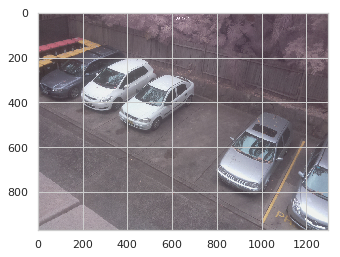

In [39]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()



In [40]:
img = cv2.imread("../input/data/data/Free/img_1006085059.jpg", cv2.IMREAD_GRAYSCALE) 
img = cv2.resize(img, (image_size, image_size)).flatten()

In [41]:
train_messy[0]

'img_914020102.jpg'

In [42]:
DIR  = "../input/data/data/Full/"

for image in (train_messy): 
    path = os.path.join(DIR,image)
    #path = image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (image_size, image_size)).flatten()   
    np_img=np.asarray(img)

        

DIR  = "../input/data/data/Free/"
    
for image2 in tqdm(train_clean): 
    path = os.path.join(DIR,image2)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img2 = cv2.resize(img2, (image_size, image_size)).flatten()   
    np_img2=np.asarray(img2)



100%|██████████| 853/853 [00:16<00:00, 55.58it/s]


In [43]:
DIR_m  = "../input/data/data/Full/"
DIR_c  = "../input/data/data/Free/"
def train_data():
    train_data_messy = [] 
    train_data_clean=[]
    for image1 in tqdm((train_messy)): 
        path = os.path.join(DIR_m,image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_messy.append(img1) 
    for image2 in tqdm((train_clean)): 
        path = os.path.join(DIR_c,image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_clean.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_messy),np.asarray(train_data_clean)),axis=0)
    return train_data 

In [44]:
def test_data():
    test_data_messy = [] 
    test_data_clean=[]
    for image1 in tqdm((test_messy)): 
        path = os.path.join(DIR_m, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_messy.append(img1) 
    for image2 in tqdm((test_clean)): 
        path = os.path.join(DIR_c, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data_clean.append(img2) 
    
    test_data= np.concatenate((np.asarray(test_data_messy),np.asarray(test_data_clean)),axis=0) 
    return test_data 

In [45]:
train_data = train_data() 
test_data = test_data()

100%|██████████| 214/214 [00:03<00:00, 57.37it/s]


In [46]:
shape(train_data)

(2609, 128, 128)

In [47]:
shape(test_data)

(653, 128, 128)

In [48]:
x_data=np.concatenate((train_data,test_data),axis=0)
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [49]:
# we must have array of 3262
z1 = np.zeros(1500)
o1 = np.ones(1500)
Y_train = np.concatenate((o1, z1), axis=0)
z = np.zeros(131)
o = np.ones(131)
Y_test = np.concatenate((o, z), axis=0)

In [50]:
y_data=np.concatenate((Y_train,Y_test),axis=0).reshape(x_data.shape[0],1)


In [51]:
print("X shape: " , x_data.shape)
print("Y shape: " , y_data.shape)

X shape:  (3262, 128, 128)
Y shape:  (3262, 1)


In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

In [53]:
x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

X train flatten (2772, 16384)
X test flatten (490, 16384)


In [54]:
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (16384, 2772)
x test:  (16384, 490)
y train:  (1, 2772)
y test:  (1, 490)


In [55]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

Cost after iteration 0: nan
Cost after iteration 100: 1.731208
Cost after iteration 200: 1.531509
Cost after iteration 300: 1.421744
Cost after iteration 400: 1.351945
Cost after iteration 500: 1.300183
Cost after iteration 600: 1.257435
Cost after iteration 700: 1.220370
Cost after iteration 800: 1.187521
Cost after iteration 900: 1.158014
Cost after iteration 1000: 1.131220
Cost after iteration 1100: 1.106667
Cost after iteration 1200: 1.083993
Cost after iteration 1300: 1.062923
Cost after iteration 1400: 1.043250


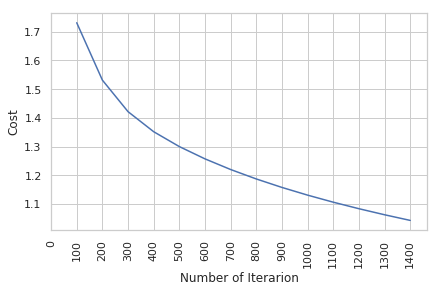

Test Accuracy: 54.69 %
Train Accuracy: 58.37 %


In [56]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 1500)


In [57]:
##   55 % accuracy of the test

In [58]:
###########################

# MLP


In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


dataset = '../input/data/data'

data_types = os.listdir(dataset)
print (data_types)  

print("Types of data found: ", len(data_types))

['Full', 'Free']
Types of data found:  2


In [60]:
rs = []

for item in data_types:
 # Get all the file names
 all_rs = os.listdir(dataset + '/' +item)
 #print(all_shoes)

 # Add them to the list
 for rm in all_rs:
    rs.append((item, str(dataset + '/' +item) + '/' + rm))
    print(rs[:1])

[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057.jpg')]
[('Full', '../input/data/data/Full/img_129092057

In [61]:
# Build a dataframe        
rs_df = pd.DataFrame(data=rs, columns=['rm type', 'image'])
print(rs_df.head())
print(rs_df.tail())

  rm type                                       image
0    Full   ../input/data/data/Full/img_129092057.jpg
1    Full  ../input/data/data/Full/img_1003232601.jpg
2    Full   ../input/data/data/Full/img_129090558.jpg
3    Full   ../input/data/data/Full/img_923073057.jpg
4    Full   ../input/data/data/Full/img_919145058.jpg
     rm type                                       image
3257    Free  ../input/data/data/Free/img_1008120557.jpg
3258    Free  ../input/data/data/Free/img_1008155558.jpg
3259    Free   ../input/data/data/Free/img_823105558.jpg
3260    Free  ../input/data/data/Free/img_1008102058.jpg
3261    Free   ../input/data/data/Free/img_818043602.jpg


In [62]:
# Let's check how many samples for each category are present
print("Total number of rs in the dataset: ", len(rs_df))

Total number of rs in the dataset:  3262


In [63]:
rm_count = rs_df['rm type'].value_counts()

print("rs in each category: ")
print(rm_count)

rs in each category: 
Full    2195
Free    1067
Name: rm type, dtype: int64


In [64]:
import cv2
path = dataset


#im_size = 100
im_size = 300

images = []
labels = []

for i in data_types:
    data_path = path +'/'+ str(i) 
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)  # reading that image as array
        #print(img)  # will get the image as an array
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [65]:
# Transform the image array to a numpy type

images = np.array(images)

images.shape

(3262, 300, 300, 3)

In [66]:
images = images.astype('float32') / 255.0


In [67]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder


y=rs_df['rm type'].values
print(y[:5])

['Full' 'Full' 'Full' 'Full' 'Full']


In [68]:
# for y
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[1 1 1 ... 0 0 0]


In [69]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, y = shuffle(images, y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(3098, 300, 300, 3)
(3098,)
(164, 300, 300, 3)
(164,)


In [70]:
# Develop a sequential model using tensorflow keras
import keras
import tensorflow as tf
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(300,300,3)),
    keras.layers.Dense(256, activation=tf.nn.tanh),
   
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [71]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 270000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               69120256  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 69,121,027
Trainable params: 69,121,027
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Compute the model parameters

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
# Train the model  with 5 epochs 

model.fit(train_x,train_y, epochs=20)

Epoch 1/20
3098/3098 [==============================] - 4s 1ms/step - loss: 0.7250 - acc: 0.6478
Epoch 2/20
3098/3098 [==============================] - 3s 922us/step - loss: 0.6372 - acc: 0.6740
Epoch 3/20
3098/3098 [==============================] - 3s 904us/step - loss: 0.6352 - acc: 0.6743
Epoch 4/20
3098/3098 [==============================] - 3s 913us/step - loss: 0.6406 - acc: 0.6743
Epoch 5/20
3098/3098 [==============================] - 3s 945us/step - loss: 0.6401 - acc: 0.6704
Epoch 6/20
3098/3098 [==============================] - 3s 991us/step - loss: 0.6380 - acc: 0.6743
Epoch 7/20
3098/3098 [==============================] - 3s 910us/step - loss: 0.6385 - acc: 0.6743
Epoch 8/20
3098/3098 [==============================] - 3s 910us/step - loss: 0.6413 - acc: 0.6743
Epoch 9/20
3098/3098 [==============================] - 3s 942us/step - loss: 0.6399 - acc: 0.6743
Epoch 10/20
3098/3098 [==============================] - 3s 900us/step - loss: 0.6422 - acc: 0.6743
Epoch 11/20

In [74]:
y_pred = model.predict_classes(test_x)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [75]:
model.evaluate(test_x , test_y)

164/164 [==============================] - 0s 1ms/step


[0.7341335226849812, 0.6463414634146342]

Take input from user
